In [111]:
import os
import requests
import json
import time
import re
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm
from pathlib import Path
from mysql.connector import Error
from datetime import datetime

In [57]:
# Define the base URL for the Best Buy API - gaming%20
BASE_URL = "https://www.bestbuy.ca/api/v2/json/search?currentRegion=ON&&page={}&pageSize=100&query=chromebooks&sortBy=relevance&sortDir=desc"

# Create a folder for storing the scraped data if it doesn't already exist
output_folder = Path("best_buy_scraped_data")
output_folder.mkdir(exist_ok=True)

error_folder = Path("best_buy_error_data")
error_folder.mkdir(exist_ok=True)

# Define headers
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1"
}

# Load environment variables
host = os.getenv("MYSQL_HOST")
user = os.getenv("MYSQL_USER")
password = os.getenv("MYSQL_PASSWORD")
database = os.getenv("MYSQL_DATABASE")

known_brands = [
    "Dell", "HP", "Lenovo", "Acer", "Asus", "Razer", "MSI", "Apple",
    "Alienware", "Samsung", "Microsoft", "Toshiba", "Sony", "Gigabyte", "EVGA",
    "Latitude", "Inspiron", "Precision", "LG", "lg", "hp", "AQVIN", "Aqvin"
]

In [32]:

# Function to save response JSON data to a file
def save_json(data, page_number):
    filename = output_folder / f"best_buy_chromebooks_page_{page_number}.json"
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)
    print(f"File saved: {filename}")

In [12]:
# Function to save error response (either JSON or raw text) and terminate
def save_error_and_terminate(response, page_number):
    try:
        # Attempt to parse the response as JSON
        data = response.json()
        filename = error_folder / f"best_buy_chromebooks_error_page_no_{page_number}.json"
        with open(filename, "w") as f:
            json.dump(data, f, indent=4)
    except json.JSONDecodeError:
        # If JSON parsing fails, save the raw text content
        filename = error_folder / f"best_buy_chromebooks_error_page_no_{page_number}.html"
        with open(filename, "w") as f:
            f.write(response.text)
    
    print(f"Error file saved: {filename}")
    print("Terminating program due to error.")
    exit()

In [34]:
# Scraping function with exponential delay

def scrape_bestbuy_laptops():
    page = 1
    exponential_delay = 0.5  # Start with a 1-second delay, will increase exponentially

    # Initial request to get total pages
    url = BASE_URL.format(page)
    print(f"Requesting page no: {page}, URL: {url}")  # Added print statement
    initial_response = requests.get(url, headers=headers)
    
    if initial_response.status_code == 200:
        data = initial_response.json()
        total_pages = data.get("totalPages", 1)
        
        # Initialize the progress bar with total pages
        # progress_bar = tqdm(total=total_pages, desc="Scraping Pages")

        # Save the first page data and move to the next page if productStatusCode is valid
        if int((data.get("productStatusCode", 0) or 0)) == 200:
            save_json(data, page)
            print(f"Page {page} scraped successfully")
            # progress_bar.update(page)
            page += 1
        else:
            print("Initial request failed with productStatusCode != 200.")
            save_error_and_terminate(initial_response, page)
            return
    else:
        print("Initial request failed to retrieve total pages.")
        save_error_and_terminate(initial_response, page)
        return

    # Loop through remaining pages
    while page <= total_pages:
        try:
            # Construct the URL with the current page number
            url = BASE_URL.format(page)
            print(f"Requesting page no: {page}, URL: {url}")  # Added print statement

            response = requests.get(url, headers=headers)

            # Check if response is OK
            if response.status_code == 200:
                data = response.json()

                # Check if response has the expected productStatusCode
                if int((data.get("productStatusCode", 0) or 0)) == 200:
                    # Save the JSON data
                    save_json(data, page)
                    print(f"Page {page} scraped successfully")
                    total_pages = data.get("totalPages", 1)
                    # progress_bar.update(1)  # Update progress bar after each successful page
                    page += 1

                else:
                    # Handle unexpected productStatusCode
                    print(f"Error in response for page {page}:")
                    save_error_and_terminate(response, page)
                    break

            else:
                # Handle non-200 status code
                print(f"Request failed for page {page} with status code {response.status_code}")
                save_error_and_terminate(response, page)
                break

        except requests.RequestException as e:
            print(f"An error occurred: {e}")
            save_error_and_terminate(response, page)
            break

        # Exponential delay after each request
        time.sleep(exponential_delay)
        #exponential_delay += 0.1  # Double the delay for the next page

    # progress_bar.close()  # Close the progress bar once scraping is complete


In [35]:
scrape_bestbuy_laptops()

Requesting page no: 1, URL: https://www.bestbuy.ca/api/v2/json/search?currentRegion=ON&&page=1&pageSize=100&query=chromebooks&sortBy=relevance&sortDir=desc
File saved: best_buy_scraped_data/best_buy_chromebooks_page_1.json
Page 1 scraped successfully
Requesting page no: 2, URL: https://www.bestbuy.ca/api/v2/json/search?currentRegion=ON&&page=2&pageSize=100&query=chromebooks&sortBy=relevance&sortDir=desc
File saved: best_buy_scraped_data/best_buy_chromebooks_page_2.json
Page 2 scraped successfully
Requesting page no: 3, URL: https://www.bestbuy.ca/api/v2/json/search?currentRegion=ON&&page=3&pageSize=100&query=chromebooks&sortBy=relevance&sortDir=desc
File saved: best_buy_scraped_data/best_buy_chromebooks_page_3.json
Page 3 scraped successfully
Requesting page no: 4, URL: https://www.bestbuy.ca/api/v2/json/search?currentRegion=ON&&page=4&pageSize=100&query=chromebooks&sortBy=relevance&sortDir=desc
File saved: best_buy_scraped_data/best_buy_chromebooks_page_4.json
Page 4 scraped successfu

In [150]:
# Connect to the MySQL database
def create_mysql_connection_cursor():
    try:
        connection = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        if connection.is_connected():
            sql_cursor = connection.cursor()
            print("Connected to MySQL database")
            return connection, sql_cursor
        return None, None
    except Error as e:
        print(f"Error: {e}")
        return None, None

In [151]:
def create_database_if_not_exists(cursor, database_name):
    cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database_name}")
    print(f"Database `{database_name}` checked/created.")


In [152]:
sql_conn, sql_cursor = create_mysql_connection_cursor()
create_database_if_not_exists(sql_cursor, database)
# SQL statement to create the table
create_table_query = """
        CREATE TABLE IF NOT EXISTS best_buy_laptops (
            sku VARCHAR(255) PRIMARY KEY,
            brand_name VARCHAR(255) NULL,
            name VARCHAR(255) NULL,
            short_description TEXT NULL,
            customer_rating FLOAT NULL,
            rating_category VARCHAR(255) NULL,
            rating_count INT NULL,
            review_count INT NULL,
            product_url VARCHAR(255) NULL,
            regular_price FLOAT NULL,
            sale_price FLOAT NULL,
            is_on_sale VARCHAR(3) NULL,
            sale_end_date DATETIME NULL,
            category_name VARCHAR(255) NULL,
            ehf FLOAT NULL,
            is_clearance VARCHAR(3) NULL,
            is_price_ends_label VARCHAR(3) NULL,
            has_promotion VARCHAR(3) NULL,
            is_advertised VARCHAR(3) NULL,
            is_in_store_only VARCHAR(3) NULL,
            is_online_only VARCHAR(3) NULL,
            is_visible VARCHAR(3) NULL
        );
        """

sql_cursor.execute(create_table_query)
    
# Commit the changes and close the connection
sql_conn.commit()
print("Table created successfully.")


Connected to MySQL database
Database `best_buy` checked/created.
Table created successfully.


In [153]:
def insert_product(product, cursor):
    # Prepare the insert statement
    columns = []
    placeholders = []
    values = []
    
    # Iterate through the product dictionary
    for key, value in product.items():
        columns.append(key)
        placeholders.append('%s')
        values.append(value)

    # Create the insert statement
    insert_query = f"""
        INSERT INTO best_buy_laptops ({', '.join(columns)}) 
        VALUES ({', '.join(placeholders)}) 
        ON DUPLICATE KEY UPDATE
        {', '.join([f"{col}=VALUES({col})" for col in columns if col != 'sku'])};
    """

    # Execute the insert statement
    try:
        cursor.execute(insert_query, values)
    except Exception as e:
        print("Error executing query:", e)



    # connection.commit()


In [103]:
def load_json_files(folder_path):
    # Iterate through all files in the specified folder
    for filename in os.listdir(folder_path):
        # Check if the file has a .json extension
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            print(f"Reading file: {file_path}")

            # Open and load the JSON data from the file
            with open(file_path, 'r', encoding='utf-8') as file:
                try:
                    data = json.load(file)
                    yield data['products'], file_path  # Yield the JSON data one at a time
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON in file {filename}: {e}")

In [137]:
# Function to convert boolean to categorical string
def boolean_to_category(value):
    return "Yes" if value else "No"

# Function to convert rating to a category
def categorize_rating(rating):
    if rating == 0:
        return "Not Rated"
    elif 0 < rating < 2:
        return "Bad Rating"
    elif 2 <= rating < 3:
        return "OK Rating"
    elif 3 <= rating < 4:
        return "Good Rating"
    elif 4 <= rating < 4.5:
        return "Great Rating"
    elif rating >= 4.5:
        return "Best Rating"
    return "Unknown Rating"

# Function to convert timestamp to date
def convert_timestamp_to_date(timestamp):
    return datetime.fromtimestamp(timestamp / 1000).strftime('%Y-%m-%d')

def is_product_on_sale(product_data):
    if product_data["regularPrice"] == product_data["salePrice"]:
        return "No"
    return "Yes"

def extract_brand(name):
    # Normalize the name by removing special characters
    normalized_name = re.sub(r'[^a-zA-Z0-9\s]', '', name)
    
    # Split the name into words
    words = normalized_name.split()
    
    # Convert known brands to lowercase for case-insensitive comparison
    lower_known_brands = [brand.lower() for brand in known_brands]
    
    # Check if the first word is a known brand
    if words:
        first_word = words[0].lower()
        if first_word in lower_known_brands:
            return known_brands[lower_known_brands.index(first_word)].title()  # Return title case
    
    # If not, search for any known brand in the name
    for brand in known_brands:
        if brand.lower() in normalized_name.lower():
            return brand.title()  # Return title case

    ignore_keywords = {'refurbished', 'excellent', 'good', 'used', 'like new', 'renewed'}

    # Check for the first word that is not in ignore keywords
    for word in words:
        lower_word = word.lower()
        if lower_word not in ignore_keywords:
            return word.title()
            
    
    # Return empty string if no brand is found
    return ""


def clean_laptop_json(product_data):
    # Add new boolean fields as categorical variables to cleaned data
    cleaned_data = {
        "sku": product_data.get("sku"),
        "brand_name": extract_brand(product_data.get("name", "")),  # Extract brand name
        "name": product_data.get("name"),
        "short_description": product_data.get("shortDescription"),
        "customer_rating": product_data.get("customerRating"),
        "rating_category": categorize_rating(product_data.get("customerRating")),  # Categorized rating
        "rating_count": product_data.get("customerRatingCount"),
        "review_count": product_data.get("customerReviewCount"),
        "product_url": "https://www.bestbuy.ca" + product_data.get("productUrl"),
        "regular_price": product_data.get("regularPrice"),
        "sale_price": product_data.get("salePrice"),
        "is_on_sale": is_product_on_sale(product_data),
        "sale_end_date": convert_timestamp_to_date(product_data["saleEndDate"]) if product_data.get("saleEndDate") else None,
        "category_name": product_data.get("categoryName"),
        "ehf": product_data.get("ehf"),
        # "seo_text": product_data.get("seoText"),
        "is_clearance": boolean_to_category(product_data.get("isClearance")),
        # "thumbnail_url": product_data.get("thumbnailImage"),
        "is_price_ends_label": boolean_to_category(product_data.get("isPriceEndsLabel")),
        "has_promotion": boolean_to_category(product_data.get("hasPromotion")),
        "is_advertised": boolean_to_category(product_data.get("isAdvertised")),
        "is_in_store_only": boolean_to_category(product_data.get("isInStoreOnly")),
        "is_online_only": boolean_to_category(product_data.get("isOnlineOnly")),
        "is_visible": boolean_to_category(product_data.get("isVisible"))
    }
    return cleaned_data

# # Convert to DataFrame for CSV export
# df = pd.DataFrame([cleaned_data])  # Wrapping in a list to handle single product

# # Save to CSV
# df.to_csv("cleaned_best_buy_laptop_data.csv", index=False)

# print("Data saved to cleaned_best_buy_laptop_data.csv")


In [138]:
for best_buy_laptop_json_list, json_full_file_name in load_json_files(output_folder):
    for laptop_json in best_buy_laptop_json_list:
        cleaned_laptop_json = clean_laptop_json(laptop_json)
        # print(json.dumps(cleaned_laptop_json, indent=4))
        insert_product(cleaned_laptop_json, sql_cursor)
        
        # brand_name = cleaned_laptop_json["brand_name"]
        # if not brand_name:
        #     print(cleaned_laptop_json["brand_name"])
        #     print(cleaned_laptop_json["name"])
        #     print("-"*100)
        # break
    sql_conn.commit()
    print("Done inserting all best buy products from file: ", json_full_file_name)
    print("-"*100, "\n")
    # break
print("Done inserting all data :D")

Reading file: best_buy_scraped_data/best_buy_macbook_page_95.json
Done inserting all best buy products from file:  best_buy_scraped_data/best_buy_macbook_page_95.json
---------------------------------------------------------------------------------------------------- 

Reading file: best_buy_scraped_data/best_buy_gaming_laptop_page_94.json
Done inserting all best buy products from file:  best_buy_scraped_data/best_buy_gaming_laptop_page_94.json
---------------------------------------------------------------------------------------------------- 

Reading file: best_buy_scraped_data/best_buy_business_laptop_page_86.json
Done inserting all best buy products from file:  best_buy_scraped_data/best_buy_business_laptop_page_86.json
---------------------------------------------------------------------------------------------------- 

Reading file: best_buy_scraped_data/best_buy_laptop_page_61.json
Done inserting all best buy products from file:  best_buy_scraped_data/best_buy_laptop_page_61.js

In [166]:
def analyze_best_buy_laptops():
    try:

        # 1. Count total number of laptops
        sql_cursor.execute("SELECT COUNT(*) FROM best_buy_laptops;")
        total_laptops = sql_cursor.fetchone()[0]
        print(f"Total number of laptops: {total_laptops}")

        # 2. Count distinct brand names
        sql_cursor.execute("SELECT COUNT(DISTINCT brand_name) FROM best_buy_laptops;")
        distinct_brands = sql_cursor.fetchone()[0]
        print(f"Number of distinct brands: {distinct_brands}")

        # 3. Count laptops by brand
        sql_cursor.execute("SELECT brand_name, COUNT(*) as count FROM best_buy_laptops GROUP BY brand_name ORDER BY count DESC;")
        brand_counts = sql_cursor.fetchall()

        # Prepare DataFrame for plotting brands
        df_brands = pd.DataFrame(brand_counts, columns=['brand_name', 'count'])

        # 4. Select top 20 brands
        top_20_brands = df_brands.head(20)

        # Plotting count of laptops by top 20 brands
        plt.figure(figsize=(12, 6))
        sns.barplot(x='count', y='brand_name', data=top_20_brands, palette='viridis', hue='brand_name', legend=False)
        plt.title('Count of Laptops by Top 20 Brands')
        plt.xlabel('Count')
        plt.ylabel('Brand Name')
        plt.grid(axis='x')
        plt.xticks(rotation=45)  # Rotate x-ticks for better visibility

        # Add data labels
        for index, value in enumerate(top_20_brands['count']):
            plt.text(value, index, str(value))

        plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
        plt.show()

        # # 5. Top 10 brands with highest ratings
        # sql_cursor.execute("""
        #     SELECT brand_name, MAX(customer_rating) as max_rating 
        #     FROM best_buy_laptops 
        #     WHERE customer_rating IS NOT NULL 
        #     GROUP BY brand_name 
        #     ORDER BY max_rating DESC 
        #     LIMIT 50;
        # """)
        # top_10_brands = sql_cursor.fetchall()
        # print("\nTop 10 Brands with Highest Ratings:")
        # for brand, avg_rating in top_10_brands:
        #     print(f"{brand}: {avg_rating:.2f}")

        # 6. Count laptops on clearance
        sql_cursor.execute("SELECT COUNT(*) FROM best_buy_laptops WHERE is_clearance = 'Yes';")
        clearance_count = sql_cursor.fetchone()[0]
        print(f"\nNumber of laptops on clearance: {clearance_count}")

        # 7. Calculate percentage of laptops on clearance
        clearance_percentage = (clearance_count / total_laptops) * 100 if total_laptops > 0 else 0
        print(f"Percentage of laptops on clearance: {clearance_percentage:.2f}%")

        # 8. Fetch category counts and ratings from the database
        sql_cursor.execute("""
            SELECT category_name, MAX(customer_rating) as max_rating 
            FROM best_buy_laptops 
            WHERE customer_rating IS NOT NULL 
            GROUP BY category_name 
            ORDER BY max_rating DESC 
            LIMIT 20;
        """)
        top_20_categories = sql_cursor.fetchall()
        print("\nTop 20 Categories with Highest Ratings:")
        for category, max_rating in top_20_categories:
            print(f"{category}: {max_rating:.2f}")

        # 9. Fetch laptops on sale
        sql_cursor.execute("SELECT COUNT(*) FROM best_buy_laptops WHERE is_on_sale = 'Yes';")
        on_sale_count = sql_cursor.fetchone()[0]
        print(f"\nNumber of laptops on sale: {on_sale_count}")

        # 7. Calculate percentage of laptops on sale
        sale_percentage = (on_sale_count / total_laptops) * 100 if total_laptops > 0 else 0
        print(f"Percentage of laptops on sale: {sale_percentage:.2f}%")

        # Plotting the existing top 20 categories
        sql_cursor.execute("SELECT category_name, COUNT(*) as count FROM best_buy_laptops GROUP BY category_name ORDER BY count DESC;")
        category_counts = sql_cursor.fetchall()
        
        # Prepare DataFrame for plotting categories
        df_categories = pd.DataFrame(category_counts, columns=['category_name', 'count'])
        
        # Select the top 20 categories directly from the fetched data
        top_20_categories = df_categories.head(20)  # Already sorted in descending order
        
        # Set the figure size
        plt.figure(figsize=(12, 8))
        
        # Create the bar plot for the top 20 categories
        sns.barplot(x='count', y='category_name', data=top_20_categories, palette='mako', hue='category_name', dodge=False)
        
        # Set the title and labels
        plt.title('Top 20 Categories of Laptops', fontsize=16)
        plt.xlabel('Count', fontsize=14)
        plt.ylabel('Category Name', fontsize=14)
        
        # Rotate y-ticks for better visibility
        plt.xticks(rotation=45)
        
        # Show the plot
        plt.tight_layout()
        plt.show()




    except mysql.connector.Error as err:
        print(f"Error: {err}")
    # finally:
    #     # Close the cursor and connection
    #     sql_cursor.close()
    #     sql_conn.close()


Total number of laptops: 44527
Number of distinct brands: 1061


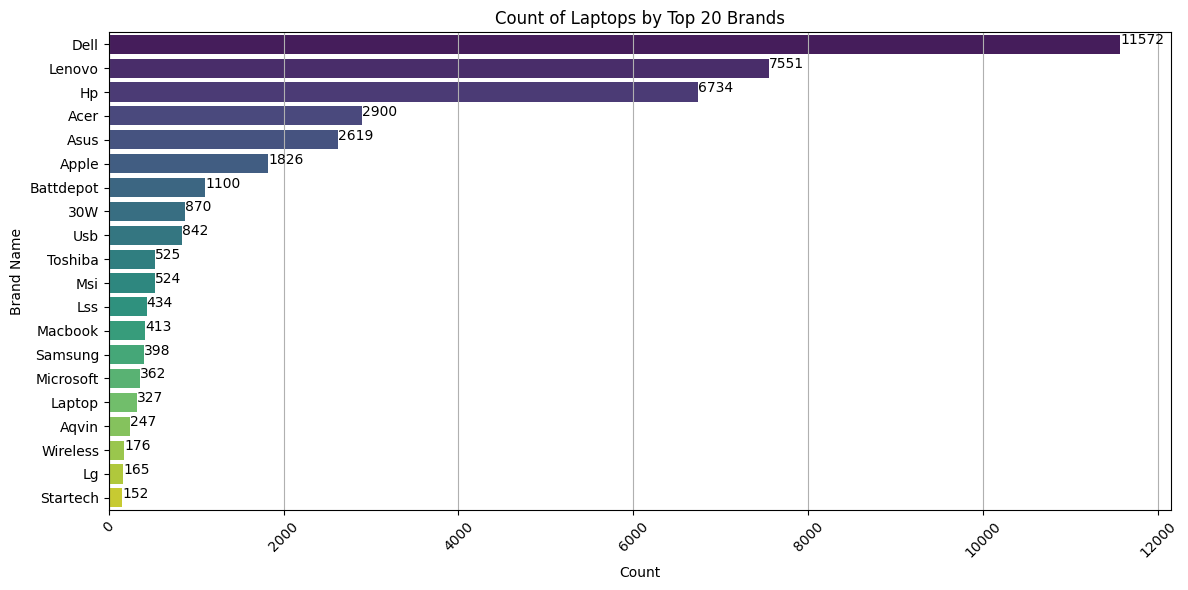


Number of laptops on clearance: 100
Percentage of laptops on clearance: 0.22%

Top 20 Categories with Highest Ratings:
Messenger Bags & Briefcases: 5.00
Splitters, Couplers & Adapters: 5.00
Other Computer Accessories: 5.00
Monitor & Video Cables: 5.00
Adapters: 5.00
Media Streamers: 5.00
Monitor Stands, Mounts & Screen Filters: 5.00
Backpacks: 5.00
Desks & Workstations: 5.00
75 - 84 Inch TVs: 5.00
Windows Laptops: 5.00
Laptop Chargers & Adapters: 5.00
Laptop Bags: 5.00
Wireless USB Adapters: 5.00
Laptop Sleeves: 5.00
Computer USB Cables: 5.00
Laptop Internal Hard Drives: 5.00
USB Hubs: 5.00
Docks, Stands & Cooling Pads: 5.00
Wireless Mice: 5.00

Number of laptops on sale: 20736
Percentage of laptops on sale: 46.57%


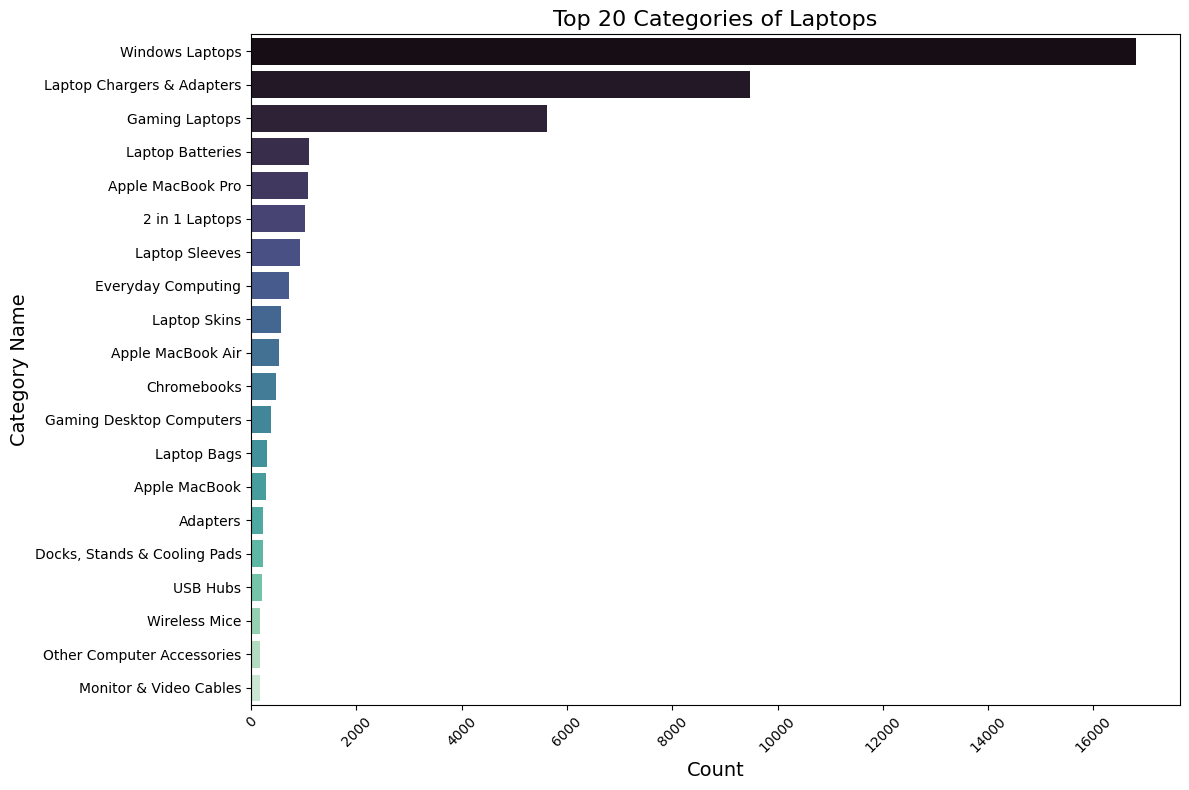

In [167]:
analyze_best_buy_laptops()

In [146]:
# SQL query to select top 20 names where brand_name is empty
sql_cursor.execute("""
    SELECT name FROM best_buy_laptops
    WHERE brand_name IS NULL OR brand_name = ''
    LIMIT 20;
""")

# Fetch the results
empty_brand_laptops = sql_cursor.fetchall()

# Convert results to a DataFrame for easier handling
df_empty_brand_laptops = pd.DataFrame(empty_brand_laptops, columns=['name'])

# Print the results in a pretty format
if not df_empty_brand_laptops.empty:
    print("Top 20 Laptops with Empty Brand Names:\n")
    for index, row in df_empty_brand_laptops.iterrows():
        print(f"{index + 1}. {row['name']}")
else:
    print("No laptops found with empty brand names.")

No laptops found with empty brand names.


In [147]:
sql_cursor.close()
sql_conn.close()
print("Sql conn and cursor closed")

Sql conn and cursor closed
